<h4>Import Library

In [1]:
import tensorflow as tf
import os
import json 
import numpy as np
import pandas as pd
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

<h4>Load and Preprocess Data

In [5]:
with open('mmimdb/split.json') as f:
    data = json.load(f) 

validate = np.array(data['dev'])
validate = validate.astype(str)
test = np.array(data['test']) 
test = test.astype(str)
train = np.array(data['train'])
train = train.astype(str)

In [4]:
def load_movie_info(df, i):
    path = 'mmimdb/dataset/' + i + '.json'
    if not os.path.exists(path):
        print(f"Warning: {path} file not found.")
        return
    with open('mmimdb/dataset/' + i + '.json') as f:
        movie_data = json.load(f)
        df.loc[i, "File_name"] = i + '.jpeg'
        for genre in ['News', 'Reality-TV', 'Talk-Show', 'Adult']:
            if genre in movie_data['genres']:
               movie_data['genres'].remove(genre)
        df.loc[i, "label"] = movie_data['genres']
        df.loc[i, "Plot"] = movie_data['plot']

In [6]:
df_train = pd.DataFrame(columns=['label','File_name','Plot','label_encode'], index=train)
for i in train:
    load_movie_info(df_train, i)

df_val = pd.DataFrame(columns=['label','File_name','Plot','label_encode'], index=validate)
for i in validate:
    load_movie_info(df_val, i)

df_test = pd.DataFrame(columns=['label','File_name','Plot','label_encode'], index=test)
for i in test:
    load_movie_info(df_test, i)

In [7]:
df_train.head()

,label,File_name,Plot,label_encode
0106714,"[Crime, Drama, Thriller]",0106714.jpeg,[Mild mannered businessman Anthony Wongs life ...,NaN
0204504,"[Action, Crime, Drama, Thriller]",0204504.jpeg,[Tough girl biker Ako (pop singer Akiko Wada) ...,NaN
1865357,[Drama],1865357.jpeg,[Roque starts University in Buenos Aires but h...,NaN
0033804,"[Comedy, Romance]",0033804.jpeg,[Returning from a year up the Amazon studying ...,NaN
0066423,[Comedy],0066423.jpeg,[Politician get hitch hikers on road and in on...,NaN


In [8]:
mlb = MultiLabelBinarizer()

def encode_movie_label(df, bFit=False):
    if bFit:
        y_bin = mlb.fit_transform(df['label'])
    else:
        y_bin = mlb.transform(df['label'])
    for i in range(len(y_bin)):
        df.iloc[i, 3] = y_bin[i, :]
    return y_bin

In [9]:
y_train_bin = encode_movie_label(df_train, bFit=True)

y_val_bin = encode_movie_label(df_val)

y_test_bin = encode_movie_label(df_test)

In [10]:
df_train.head()

,label,File_name,Plot,label_encode
0106714,"[Crime, Drama, Thriller]",0106714.jpeg,[Mild mannered businessman Anthony Wongs life ...,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
0204504,"[Action, Crime, Drama, Thriller]",0204504.jpeg,[Tough girl biker Ako (pop singer Akiko Wada) ...,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1865357,[Drama],1865357.jpeg,[Roque starts University in Buenos Aires but h...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
0033804,"[Comedy, Romance]",0033804.jpeg,[Returning from a year up the Amazon studying ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
0066423,[Comedy],0066423.jpeg,[Politician get hitch hikers on road and in on...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<h4>Train Neutral Network

In [12]:
#set variables
img_width, img_height = 224, 224
data_dir = 'mmimdb/dataset/'
nb_train_samples = len(train)
nb_validation_samples = len(validate)
epochs = 15
batch_size = 12
class_weight = {}
temp_weight = 1 - (y_train_bin.sum(axis=0) / y_train_bin.sum())
for i in range(len(temp_weight)):
    class_weight[i] = temp_weight[i]

In [13]:
image_data_generator = ImageDataGenerator(validation_split=0, rescale=1. / 255)

train_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=data_dir,
    x_col='File_name',
    y_col='label' ,
    class_mode='categorical',
    target_size=(img_width, img_height ),
    batch_size=batch_size,
    shuffle=False 
)

validation_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_val,
    directory=data_dir,
    x_col='File_name',
    y_col='label',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False  
)

test_generator = image_data_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=data_dir,
    x_col='File_name',
    y_col='label',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False  
)

Found 15552 validated image filenames belonging to 23 classes.
Found 2608 validated image filenames belonging to 23 classes.
Found 7799 validated image filenames belonging to 23 classes.


In [14]:
extractor = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
pool = keras.layers.GlobalAveragePooling2D()(extractor.output)
dense1 = keras.layers.Dense(32, activation="relu")(pool)
drop1 = keras.layers.Dropout(0.2)(dense1)
dense2 = keras.layers.Dense(23, activation="sigmoid")(drop1)
movie_poster_model = keras.models.Model(inputs=[extractor.input], outputs=[dense2])

In [16]:
for layer in movie_poster_model.layers[-23:]:
    layer.trainable = True

movie_poster_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                           metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
movie_poster_model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    class_weight=class_weight)

In [ ]:
movie_poster_model.save('movie_poster.h5')

<h4>Evaluate Model

In [9]:
from tensorflow.keras.models import load_model

In [45]:
movie_poster_model = load_model('movie_poster.h5')

In [46]:
predict = movie_poster_model.predict(test_generator)

In [62]:
def binary_prediction(prob, threshold=0.5):
    '''
    Convert a list-like of category probabilities to binary using certain threshold.
    
    :param prob: List of probabilities.
    :param threshold: Probabilities greater than or equal to threshold is true, otherwise false.
    :return List-like of predicted categories.
    '''
    pred_cat = np.multiply(prob > threshold, 1)
    return pred_cat

In [63]:
# use threshold of 0.5 to make predictions

y_pred = binary_prediction(predict, threshold=0.5)

In [121]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [50]:
print(classification_report(y_test_bin, y_pred, target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

      Action       0.50      0.22      0.31      1044
   Adventure       0.55      0.01      0.03       821
   Animation       1.00      0.06      0.11       306
   Biography       0.00      0.00      0.00       411
      Comedy       0.67      0.38      0.48      2611
       Crime       0.49      0.05      0.08      1163
 Documentary       0.09      0.00      0.00       629
       Drama       0.64      0.70      0.67      4142
      Family       0.83      0.17      0.28       518
     Fantasy       0.40      0.01      0.01       585
   Film-Noir       0.00      0.00      0.00       102
     History       0.00      0.00      0.00       345
      Horror       0.58      0.14      0.23       825
       Music       0.00      0.00      0.00       311
     Musical       0.27      0.02      0.03       253
     Mystery       0.00      0.00      0.00       617
     Romance       0.50      0.12      0.20      1590
      Sci-Fi       0.47    

In [74]:
thresholds = np.arange(0.0, 1.0, 0.05)
thresholds = np.append(thresholds, 1.0)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [81]:
f1_scores = [f1_score(y_test_bin, binary_prediction(predict, threshold=x), average='micro', zero_division=0) for x in thresholds]

In [83]:
roc_auc_scores = [roc_auc_score(y_test_bin, binary_prediction(predict, threshold=x), average='micro') for x in thresholds]

In [88]:
f1_scores

[0.19492118120021937,
 0.33308355189209443,
 0.41004642666869623,
 0.44773716191608043,
 0.46035484377453295,
 0.4601823708206687,
 0.4513842375530252,
 0.4355155433370594,
 0.4142935821427414,
 0.38880077236052685,
 0.35953580030654697,
 0.32989532609945943,
 0.2923392778068516,
 0.2549300522501264,
 0.21520601556659774,
 0.16964203973267417,
 0.12063794334682218,
 0.07470188232975263,
 0.03766345231483819,
 0.006787330316742081,
 0.0]

In [90]:
y_pred_best_f1 = binary_prediction(predict, threshold=0.2)

In [92]:
print(classification_report(y_test_bin, y_pred_best_f1, target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

      Action       0.31      0.56      0.40      1044
   Adventure       0.29      0.24      0.26       821
   Animation       0.68      0.32      0.44       306
   Biography       0.09      0.01      0.02       411
      Comedy       0.46      0.78      0.58      2611
       Crime       0.27      0.37      0.31      1163
 Documentary       0.15      0.12      0.13       629
       Drama       0.56      0.96      0.71      4142
      Family       0.48      0.38      0.43       518
     Fantasy       0.27      0.13      0.18       585
   Film-Noir       0.00      0.00      0.00       102
     History       0.00      0.00      0.00       345
      Horror       0.39      0.45      0.42       825
       Music       0.08      0.01      0.02       311
     Musical       0.21      0.14      0.17       253
     Mystery       0.14      0.11      0.13       617
     Romance       0.32      0.57      0.41      1590
      Sci-Fi       0.32    

<h4>OneVsRestClassification and RandomForest

In [2]:
import os
import json 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
with open('mmimdb/split.json') as f:
    data = json.load(f) 

test = np.array(data['test']) 
test = test.astype(str)
train = np.array(data['train'])
train = train.astype(str)

In [39]:
import cv2

def load_pixels(df, path):
    pixels = [];
    count = 0
    for i in df.index:
        count += 1
        image = cv2.imread(path + df.loc[i, "File_name"])
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (224, 224))
        pixels.append(np.reshape(resize, -1))
    df["pixels"] = pixels;

In [40]:
load_pixels(df_train, "mmimdb/dataset/")

In [92]:
df_train.head()

,label,File_name,Plot,label_encode,pixels
0106714,"[Crime, Drama, Thriller]",0106714.jpeg,[Mild mannered businessman Anthony Wongs life ...,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[108, 51, 54, 51, 52, 48, 49, 50, 50, 50, 50, ..."
0204504,"[Action, Crime, Drama, Thriller]",0204504.jpeg,[Tough girl biker Ako (pop singer Akiko Wada) ...,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 9..."
1865357,[Drama],1865357.jpeg,[Roque starts University in Buenos Aires but h...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[68, 68, 67, 67, 66, 62, 55, 54, 57, 60, 65, 6..."
0033804,"[Comedy, Romance]",0033804.jpeg,[Returning from a year up the Amazon studying ...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[97, 53, 50, 49, 49, 50, 50, 50, 50, 50, 50, 5..."
0066423,[Comedy],0066423.jpeg,[Politician get hitch hikers on road and in on...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[219, 218, 218, 219, 225, 224, 236, 224, 221, ..."


In [93]:
X_train = []
y_train = []
for i in df_train.index:
    X_train.append(df_train.loc[i, "pixels"])
    y_train.append(list(df_train.loc[i, "label_encode"]))

In [47]:
load_pixels(df_test, "mmimdb/dataset/")

In [96]:
X_test = []
y_test = []
for i in df_test.index:
    X_test.append(df_test.loc[i, "pixels"])
    y_test.append(list(df_test.loc[i, "label_encode"]))

In [99]:
from sklearn.decomposition import PCA

In [100]:
pca = PCA(n_components=2000)

In [101]:
pca.fit(X_train)

PCA(n_components=2000)

In [102]:
pca.explained_variance_ratio_

array([3.20339714e-01, 6.03318701e-02, 4.57642453e-02, ...,
       2.38145278e-05, 2.37954776e-05, 2.37582538e-05])

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

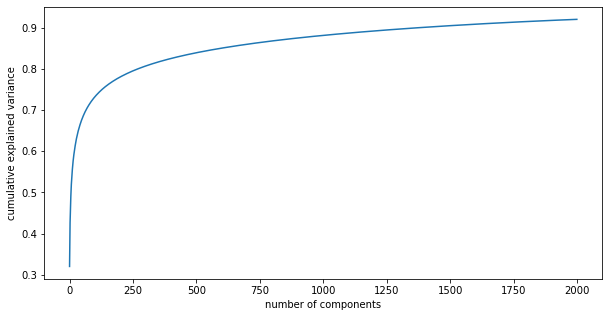

In [123]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [105]:
X_train_pca = pca.transform(X_train)

In [107]:
ovr_rf = OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1)

In [108]:
ovr_rf = ovr_rf.fit(X_train_pca, y_train)

In [106]:
X_test_pca = pca.transform(X_test)

In [109]:
y_pred = ovr_rf.predict(X_test_pca)

In [114]:
pred_category = mlb.inverse_transform(y_pred)

In [117]:
df_test["prediction"] = pred_category

In [125]:
df_test[["label", "prediction"]].sort_values(by='prediction', ascending=False).head(50)

,label,prediction
0215575,"[Short, Comedy, Fantasy]","(Short,)"
0233418,"[Thriller, Crime, Drama]","(Romance,)"
0430164,"[Horror, Mystery, Thriller]","(Horror, Thriller)"
0159241,"[Short, Horror]","(Horror, Short)"
0245929,"[Comedy, Drama, War]","(Drama, Thriller)"
0477424,[Documentary],"(Drama, Romance)"
0026184,"[Comedy, Crime, Drama, Mystery]","(Drama, Musical)"
0025346,[Drama],"(Drama, Musical)"
0076257,[Comedy],"(Drama,)"
0107711,"[Action, Crime, Drama, Romance, Thriller]","(Drama,)"


In [122]:
print(classification_report(y_test_bin, y_pred, target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

      Action       1.00      0.00      0.01      1044
   Adventure       1.00      0.00      0.00       821
   Animation       1.00      0.02      0.04       306
   Biography       0.67      0.00      0.01       411
      Comedy       0.47      0.03      0.05      2611
       Crime       0.67      0.00      0.00      1163
 Documentary       1.00      0.00      0.01       629
       Drama       0.55      0.79      0.65      4142
      Family       1.00      0.00      0.00       518
     Fantasy       1.00      0.00      0.00       585
   Film-Noir       0.00      0.00      0.00       102
     History       1.00      0.00      0.01       345
      Horror       1.00      0.00      0.00       825
       Music       0.00      0.00      0.00       311
     Musical       0.00      0.00      0.00       253
     Mystery       1.00      0.00      0.00       617
     Romance       0.00      0.00      0.00      1590
      Sci-Fi       0.50    

<h4>Extra Plots and Figures

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

In [ ]:
# choose some movies posters
movie_posters = ['mmimdb/dataset/'+test[10]+'.jpeg', 'mmimdb/dataset/'+test[20]+'.jpeg', 'mmimdb/dataset/'+test[30]+'.jpeg', 'mmimdb/dataset/'+test[40]+'.jpeg']
movie_ims = [keras.preprocessing.image.load_img(i, target_size=(224, 224, 3)) for i in movie_posters]
movie_ims = np.array(list(map(np.array, ims)))
movie_ims_prep = keras.applications.mobilenet.preprocess_input(movie_ims.copy())

In [ ]:
df_test.label[[test[10],test[20],test[30],test[40]]]

In [ ]:
preds = movie_poster_model.predict(movie_ims_prep)
labs = mlb.classes_
fig, ax = plt.subplots(4, 2, figsize=(10,20))
for i in range(4):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].barh(labs,preds[i], color="k")
fig.tight_layout()

In [ ]:
game_covers = ['games/azura_1.jpg','games/azura_2.jpg','games/calista.jpg','games/gally.jpg','games/velvet.jpg','games/gta.jpeg','games/cod.jpg']
game_ims = [keras.preprocessing.image.load_img(i, target_size=(224, 224, 3)) for i in game_covers]
game_ims = np.array(list(map(np.array, ims)))
game_ims_prep = keras.applications.mobilenet.preprocess_input(game_ims.copy())

In [ ]:
preds = movie_poster_model.predict(game_ims_prep)
labs = mlb.classes_
fig, ax = plt.subplots(7, 2, figsize=(10,20))
for i in range(7):
    ax[i, 0].imshow(ims[i]); ax[i, 0].axis("off")
    ax[i, 1].barh(labs,preds[i], color="k")
fig.tight_layout()